# Compare REM and HAND approaches

In [94]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import py3dep
import rasterio
import rioxarray
from pynhd import NHD, prepare_nhdplus
import whitebox
from shapely import box
import xrspatial
import pysheds
import shapely

import os
import tempfile

In [95]:
xmin = -119.86
xmax = -119.785
ymin = 34.00579
ymax = 34.0408

aoi = box(xmin, ymin, xmax, ymax)
aoi_with_buffer = box(xmin-.03, ymin-.03, xmax+.03, ymax+.03)
# this helps with NoData values at boundaries during operations

In [96]:
nhd = NHD('flowline_mr')

dem = py3dep.get_map("DEM", aoi_with_buffer, resolution=10, geo_crs=4326, crs=4326)
flow = nhd.bygeom(aoi, geo_crs=4326)

In [97]:
dem = dem.rio.reproject(3310)
flow = flow.to_crs(3310)

In [98]:
# get coordinates of start and end of each flowline
# keep only the one with the lowest elevation
def get_pour_point(flowline, dem):
    start_point = shapely.Point(flowline.coords[0])
    end_point = shapely.Point(flowline.coords[-1])
    elev_start_point = get_elev(start_point, dem)
    elev_end_point = get_elev(end_point, dem)

    if elev_start_point > elev_end_point:
        return shapely.Point(end_point)
    else:
        return shapely.Point(start_point)

def get_elev(point, dem):
    z = dem.sel(x=point.x, y=point.y, method='nearest').item()
    return z

In [99]:
# clip each line to the bounds and get pour points
flow['geometry'] = flow['geometry'].apply(lambda x: x.intersection(box(*dem.rio.bounds())))
pour_points = gpd.GeoSeries([get_pour_point(line, dem=dem) for line in flow['geometry']], index=flow.index)
pour_points.head(4)

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


0    POINT (16538.204 -441104.610)
1    POINT (13094.807 -444143.381)
2    POINT (12251.435 -443761.119)
3    POINT (22289.259 -445192.015)
dtype: geometry

In [100]:
for geom in flow['geometry']:
    start_point = shapely.Point(geom.coords[0])
    end_point = shapely.Point(geom.coords[-1])
    zs = get_elev(start_point, dem)
    ze = get_elev(end_point, dem)
    print (zs, ze)

343.4151306152344 76.72875213623047
80.9625473022461 57.64083480834961
415.9800720214844 26.26675796508789
388.6767272949219 220.02203369140625
170.47959899902344 2.5368337631225586
369.3789978027344 146.95254516601562
211.63856506347656 171.84808349609375
420.4227600097656 0.09263994544744492
588.5973510742188 23.914688110351562
124.44918823242188 21.815593719482422
205.2130584716797 34.220977783203125
289.72576904296875 57.64083480834961
179.30242919921875 148.2975311279297
287.4120178222656 171.84808349609375
283.335693359375 80.9625473022461
49.23541259765625 34.220977783203125
85.64688873291016 80.9625473022461
171.84808349609375 49.23541259765625
342.6150817871094 184.0909423828125
302.394287109375 18.705196380615234
552.8755493164062 5.713351726531982
57.64083480834961 49.23541259765625
352.8729248046875 180.65484619140625
121.86700439453125 85.64688873291016
429.2348327636719 121.86700439453125
402.909423828125 180.65484619140625
148.2975311279297 121.86700439453125
180.6548461

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

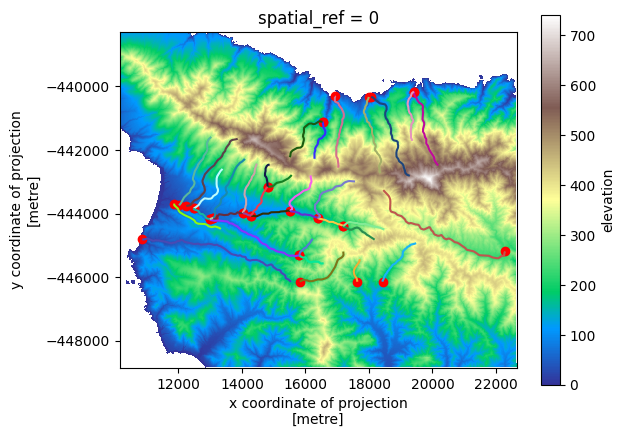

In [102]:
fig, ax = plt.subplots()
colors = [tuple(c) for c in np.random.rand(len(flow['geometry']), 3)]

dem.where(dem > 0).plot(ax=ax, cmap='terrain')
flow['geometry'].plot(ax=ax, color=colors)
pour_points.plot(ax=ax, color='red')

use whiteboxtools:
- filldepressions
- d8pointer
- rasterizeStreams
- subbasins
- hillslopes
- ElevationAboveStream

In [103]:
def wb_wrapper(wbt_method, params, return_file=False):
    
    # for each param that is raster, save to file
    for p,v in params.items():
        if hasattr(v, 'rio'):
            # write v to temp file
            # update v to be the path to that file
            temp_file = tempfile.NamedTemporaryFile(suffix=".tif")
            v.rio.to_raster(temp_file.name, driver="GTiff")
            params[p] = temp_file.name
                

    # make function call
    wbt_method(**params)

    if return_file:
        return params['output']

    raster_file_path = params['output']
    output_raster = rioxarray.open_rasterio(raster_file_path)
    os.remove(raster_file_path)
    return output_raster 

def my_callback(value):
    if not "%" in value:
        print(value)

In [104]:
wbt = whitebox.WhiteboxTools()
wbt.set_whitebox_dir("/Users/arthurkoehl/opt/WBT/")

working_directory = "/Users/arthurkoehl/programs/pasternack/valleys/"
wbt.set_working_dir(os.path.abspath(working_directory))
wbt.version()

"WhiteboxTools v2.3.0 (c) Dr. John Lindsay 2017-2023\n\nWhiteboxTools is an advanced geospatial data analysis platform developed at\nthe University of Guelph's Geomorphometry and Hydrogeomatics Research \nGroup (GHRG). See www.whiteboxgeo.com for more details.\n"

In [105]:
params = {
    "dem": dem,
    "output": os.path.join(working_directory, "filled_dem.tif"),
    "dist": 1000,
    "max_cost": None,
    "min_dist": True,
    "flat_increment": None,
    "fill": True,
    "callback": my_callback
}

filled_dem_file = wb_wrapper(wbt.breach_depressions_least_cost, params, return_file=True)
filled_dem_file

./whitebox_tools --run="BreachDepressionsLeastCost" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --dem='/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/tmpnzcxk_ht.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/filled_dem.tif' --dist='1000' --min_dist --fill -v --compress_rasters=False

*****************************************
* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Num. solved pits: 193579
Num. unsolved pits: 0
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.841s


'/Users/arthurkoehl/programs/pasternack/valleys/filled_dem.tif'

In [106]:
# d8 pointer
params = {
    "dem": filled_dem_file, 
    "output": os.path.join(working_directory, "d8_pntr.tif"), 
    "esri_pntr": False, 
    "callback": my_callback
}
d8_pntr_file = wb_wrapper(wbt.d8_pointer, params, return_file=True)

# note that to plot this need to take into account the nodata value, e.g:
# test = rioxarray.open_rasterio(d8_pntr_file)
# test.where(test != -32578).plot()

./whitebox_tools --run="D8Pointer" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --dem='/Users/arthurkoehl/programs/pasternack/valleys/filled_dem.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.49s


In [107]:
# rasterize streams
flow.to_file(os.path.join(working_directory, 'flow.shp'))

params = {
    'streams': os.path.join(working_directory, 'flow.shp'),
    'base': d8_pntr_file,
    'output': os.path.join(working_directory, "streams.tif"), 
    'nodata': True, 
    'feature_id': True, 
    'callback': my_callback
}

stream_raster_file = wb_wrapper(wbt.rasterize_streams, params, return_file=True)

./whitebox_tools --run="RasterizeStreams" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --streams='/Users/arthurkoehl/programs/pasternack/valleys/flow.shp' --base='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --nodata --feature_id -v --compress_rasters=False

*******************************
* Welcome to RasterizeStreams *
* Powered by WhiteboxTools    *
* www.whiteboxgeo.com         *
*******************************
Reading streams data...
Reading base raster data...
Counting stream cell adjacencies...
Number of stream cells: 5624
Number of stream collisions: 0
Number of stream adjacencies: 6
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.22s


/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/ipykernel_77799/3565732380.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  flow.to_file(os.path.join(working_directory, 'flow.shp'))


./whitebox_tools --run="Subbasins" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --streams='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/basins.tif' -v --compress_rasters=False

****************************
* Welcome to Subbasins     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.136s


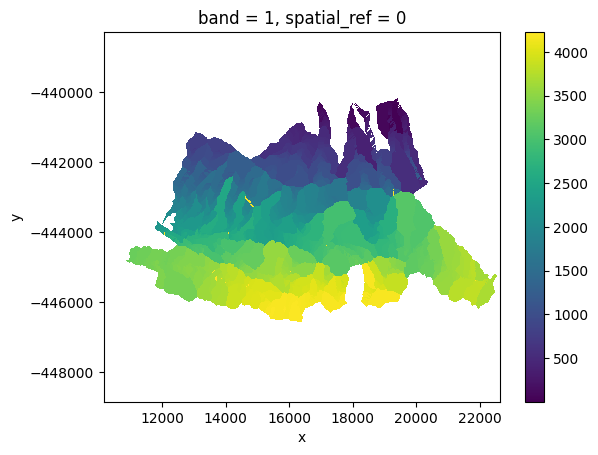

In [108]:
# subbasins
params = {
    'd8_pntr': d8_pntr_file,
    'streams': stream_raster_file, 
    'output': os.path.join(working_directory, "basins.tif"), 
    'esri_pntr': False, 
    'callback': my_callback
}
basins = wb_wrapper(wbt.subbasins, params, return_file=False)
basins.where(basins != -32768).plot()

./whitebox_tools --run="Hillslopes" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --streams='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/basins.tif' -v --compress_rasters=False

****************************
* Welcome to Hillslopes    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.167s


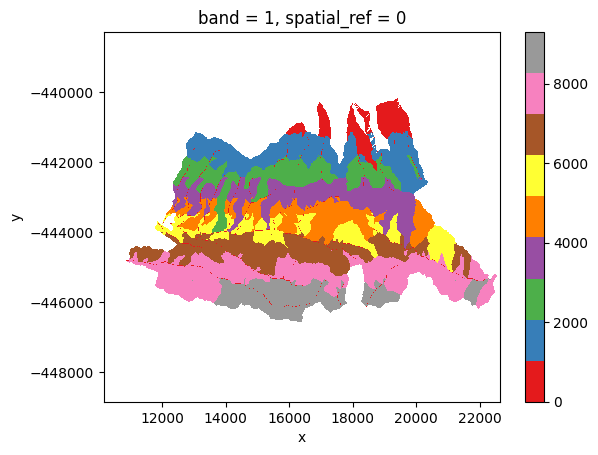

In [109]:
# hillslopes
params = {
    'd8_pntr': d8_pntr_file,
    'streams': stream_raster_file, 
    'output': os.path.join(working_directory, "basins.tif"), 
    'esri_pntr': False, 
    'callback': my_callback
}
hillslopes = wb_wrapper(wbt.hillslopes, params, return_file=False)
hillslopes.where(hillslopes != -32768).plot(cmap='Set1')

In [115]:
# snap pour points
# save pour points to shapefile
pour_points.to_file(os.path.join(working_directory, 'pp.shp'))

params = {
    'pour_pts': os.path.join(working_directory, 'pp.shp'), 
    'streams': stream_raster_file, 
    'output': os.path.join(working_directory, 'snapped_pp.shp'), 
    'snap_dist': 1000, # in meters
    'callback': my_callback
}

pour_points_file = wb_wrapper(wbt.jenson_snap_pour_points, params, return_file=True)
# read in the shape file
pour_points_snapped = gpd.GeoDataFrame.from_file(pour_points_file)
pour_points_snapped.head(5)

./whitebox_tools --run="JensonSnapPourPoints" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --pour_pts='/Users/arthurkoehl/programs/pasternack/valleys/pp.shp' --streams='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/snapped_pp.shp' --snap_dist='1000' -v --compress_rasters=False

***********************************
* Welcome to JensonSnapPourPoints *
* Powered by WhiteboxTools        *
* www.whiteboxgeo.com             *
***********************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.3s


,FID,geometry
0,0,POINT (16534.457 -441107.482)
1,1,POINT (13096.480 -444145.695)
2,2,POINT (12246.980 -443765.918)
3,3,POINT (22291.070 -445195.077)
4,4,POINT (10867.792 -444815.301)


./whitebox_tools --run="Watershed" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --pour_pts='/Users/arthurkoehl/programs/pasternack/valleys/snapped_pp.shp' --output='/Users/arthurkoehl/programs/pasternack/valleys/watersheds.tif' -v --compress_rasters=False

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.93s


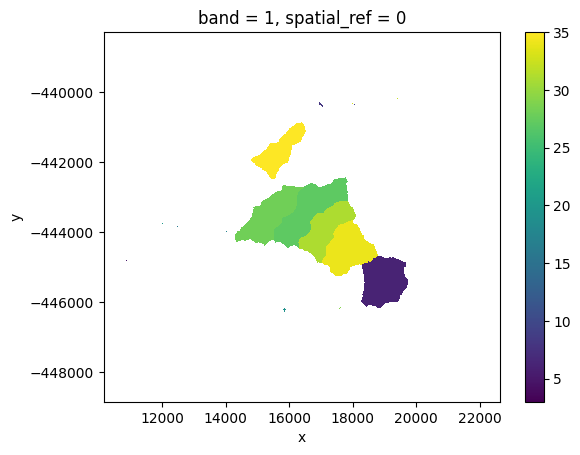

In [116]:
# watershed
params = {
    'd8_pntr': d8_pntr_file, 
    'pour_pts': pour_points_file, 
    'output': os.path.join(working_directory, 'watersheds.tif'), 
    'esri_pntr': False, 
    'callback': my_callback
}
watersheds = wb_wrapper(wbt.watershed, params, return_file=False)
watersheds.where(watersheds != -32768).plot()

In [130]:
# ElevationAboveStream

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

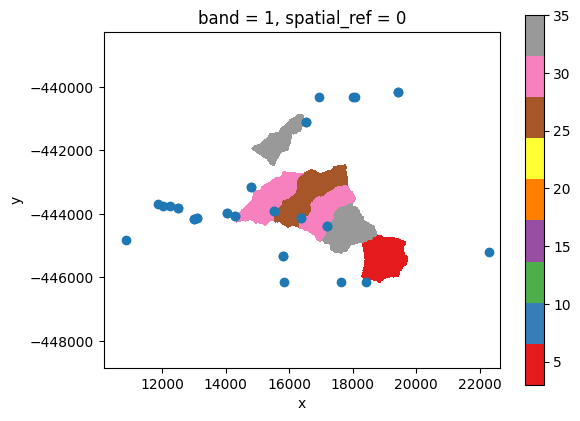

In [112]:
fig, ax = plt.subplots()
watersheds.where(watersheds != -32768).plot(ax=ax, cmap='Set1')
pour_points.plot(ax=ax)